## 1-D electromagnetic simulations using flux density formulation

In [1]:
# size of 1-D line
KE = 200;

pi = 3.14159;
kc = div((KE + 1),2);
ddx = 0.01;
dt = (ddx/6)/(10^(8));
epsz = 8.8/(10^(12));
t0 = 50;
spread = 20;
ga = fill(1, (1, KE));
gb = zeros(KE);
ex = zeros(KE);
dx = zeros(KE);
hy = zeros(KE);
ix = zeros(KE);
ex_low_m2 = 0; ex_low_m1 = 0; ex_high_m2 = 0; ex_high_m1 = 0;

In [2]:
println("Epsilon: ");
epsilon = parse(Float64,readline(STDIN));
println("Conductivity ");
sigma = parse(Float64,readline(STDIN));
println("Dielectric starts at: ");
kstart= parse(UInt64,readline(STDIN));

Epsilon: 
STDIN> 1
Conductivity 
STDIN> 0.01
Dielectric starts at: 
STDIN> 1


In [3]:
ga = fill((1/(epsilon + sigma*dt/epsz)),(130, KE));
gb = fill((sigma*dt/epsz), (130, KE));

In [24]:
T = 0; nsteps = 20;
#while nsteps>0
        
    for n = 1:nsteps
        T = T + 1;
        for k = 2:KE
            dx[k] = dx[k] + 0.5*(hy[k-1] - hy[k]);
        end
        freq_in = 3*10^8;
        pulse = exp(-0.5*abs2((t0 - T)/spread));
        dx[kc] = dx[kc] + pulse;
        
        for k = 1:(KE-1)
            ex[k] = ga[k]*(dx[k] - ix[k]);
            ix[k] = ix[k] + gb[k]*ex[k];
        end
        
        #Boundary conditions
        ex[1] = ex_low_m2;
        ex_low_m2 = ex_low_m1;
        ex_low_m1 = ex[2];
        ex[KE] = ex_high_m2;
        ex_high_m2 = ex_high_m1;
        ex_high_m1 = ex[KE-1];
        
        for k = 1:KE-1
            hy[k] = hy[k] + 0.5*(ex[k] - ex[k+1]);
        end
    end
    #nsteps = nsteps - 1;
#end


INFO: Building Rmath


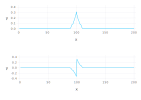

In [25]:
Pkg.build("Gadfly");
using Gadfly
vstack(plot(x=collect(1:KE), y = ex, Geom.line), plot(x=collect(1:KE), y = hy, Geom.line))

### Calculating Frequency domain output using Fourier Transform

In [82]:
ga = fill(1, (1, KE));
gb = zeros(KE);
ex = zeros(KE);
dx = zeros(KE);
hy = zeros(KE);
ix = zeros(KE);
ex_low_m2 = 0; ex_low_m1 = 0; ex_high_m2 = 0; ex_high_m1 = 0;
real_pt = fill(0.0, (5, KE));
imag_pt = fill(0.0, (5, KE));
ampn = fill(0.0, (5, KE));
phasen = fill(0.0, (5, KE));
real_in = zeros(5); imag_in = zeros(5); amp_in = zeros(5); phase_in = zeros(5); arg = zeros(5);
freq = zeros(5);
freq[1] = 100*10^6;
freq[2] = 200*10^6;
freq[3] = 500*10^6;
for i = 1:3
    arg[i] = 2*pi*freq[i]*dt;
end
ga = fill((1/(epsilon + sigma*dt/epsz)),(130, KE));
gb = fill((sigma*dt/epsz), (130, KE));

In [83]:
T=0;
for n = 1:nsteps
    T=T+1;
    for  k =2:KE
        dx[k] =  dx[k] + 0.5*(hy[k-1] + hy[k]);
    end
    
    pulse = exp(0.5 * abs2((t0 - T)/spread));
    dx[kc] = dx[kc] + pulse;
    
    for k =1:KE-1
        ex[k] = ga[k] * (dx[k] - ix[k]);
        ix[k] = ix[k] + gb[k]*ex[k];
    end
    
    for k = 1:KE
        for m = 1:3
            real_pt[m,k] = real_pt[m,k] + cos(arg[m]*T)*ex[k];
            imag_pt[m,k] = imag_pt[m,k] - sin(arg[m]*T)*ex[k];
        end
    end
    
    if T<100
        for m = 1:3
            real_in[m] = real_in[m] + cos(arg[m]*T)*ex[KE];
            imag_in[m] = imag_in[m] - sin(arg[m]*T)*ex[KE];
        end
    end
    
    #Boundary conditions
    ex[1] = ex_low_m2;
    ex_low_m2 = ex_low_m1;
    ex_low_m1 = ex[2];
    ex[KE] = ex_high_m2;
    ex_high_m2 = ex_high_m1;
    ex_high_m1 = ex[KE-1];
        
    for k = 1:KE-1
        hy[k] = hy[k] + 0.5*(ex[k] - ex[k+1]);
    end
    
end

In [84]:
#Calculating amplitude and phase of each freq

for m = 1:3
    amp_in[m] = sqrt(abs2(imag_in[m]) + abs2(real_in[m]));
    phase_in[m] = atan2(imag_in[m], real_in[m]);
    
    for k = 2:KE
        ampn[m,k] = (1/amp_in[m]) * sqrt(abs2(real_pt[m,k]) + abs2(imag_pt[m,k]));
        phasen[m,k] = atan2(imag_pt[m,k], real_pt[m,k]) - phase_in[m];
    end
    
end


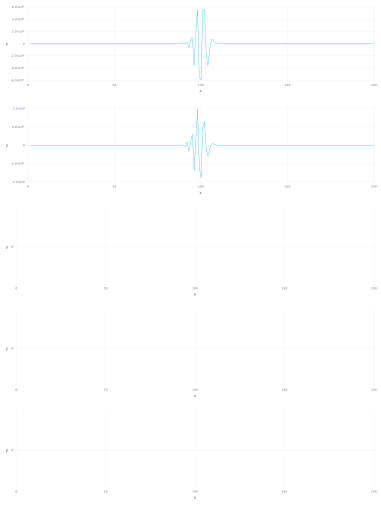

In [85]:
using Gadfly
draw(SVGJS(15inch, 20inch), vstack(plot(x=collect(1:KE), y = ex, Geom.line), plot(x=collect(1:KE), y = hy, Geom.line), plot(x = collect(1:KE), y = ampn[1,:], Geom.line), plot(x = collect(1:KE), y = ampn[2,:], Geom.line), plot(x = collect(1:KE), y = ampn[3,:], Geom.line)))

### Frequency Dependence